# Optimal Strategy

In [2]:
import os
import sys
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
sys.path.insert(0, r'../../../quetzal')

from quetzal.model import stepmodel
import pandas as pd

In [3]:
training_folder = '../../'
plot_path = training_folder + 'outputs/plot/'

# Read Model

In [5]:
sm = stepmodel.read_zippedpickles((training_folder + r'model/{scen}/walk_model'.format(scen=scenario)))

distribution = stepmodel.read_zippedpickles((training_folder + r'model/{scen}/distribution'.format(scen=scenario)))
sm.volumes = distribution.volumes

volumes: 100%|██████████| 3/3 [00:00<00:00, 629.84it/s]


# Preparation

In [9]:
tc = sm.copy()

# Keep relevant OD
v = sm.volumes.set_index(['origin', 'destination'])[["car_owner","pt_captive"]].sum(axis=1)
od_set = set(v.loc[v > 1].index)

# Walk time on road
tc.road_links['walk_time'] = tc.road_links['length']*3.6/4

# Set boarding and alighting time
tc.links['boarding_time'] = 0
tc.links['alighting_time'] = 0

tc.links['trip_id'] = tc.links['trip_id'].apply(lambda i: i.replace(':', '_').replace(' ', '_'))
tc.links = tc.links.loc[tc.links['a'] != tc.links['b']]

# Strategy Finder

In [10]:
tc.step_strategy_finder(walk_on_road=True, od_set=od_set)

100%|██████████| 110/110 [00:23<00:00,  4.75it/s]


In [11]:
tc.analysis_strategy_time(walk_on_road=True)

100%|██████████| 110/110 [00:06<00:00, 17.40it/s]


# Assignment

In [12]:
tc.step_strategy_assignment(volume_column='pt_captive', od_set=od_set)

100%|██████████| 110/110 [00:09<00:00, 11.29it/s]


In [13]:
#download graphviz and put it on the right folder 
#https://gitlab.com/api/v4/projects/4207231/packages/generic/graphviz-releases/5.0.1/windows_10_msbuild_Release_graphviz-5.0.1-win32.zi
from graphviz import Source

from IPython.display import Image
try:
        os.environ["PATH"] += os.pathsep + r'C:\Users\mlary\python\Graphviz\bin/'
        from IPython.core import display
        import numpy as np
        import networkx as nx

        tc.links['trip_id'] = tc.links['trip_id'].apply(lambda i: i.replace(':', '_').replace(' ', '_'))
        origin,destination = 'zone_72',  'zone_105'
        visualisation = tc.display_aggregated_edges(origin, destination, ranksep=0.5, rankdir='LR', irrelevant_nodes=set(tc.road_nodes.index))
except :

        visualisation = Image(training_folder + 'inputs/optimal_path/optimal.png')
visualisation

ModuleNotFoundError: No module named 'graphviz'

In [34]:
import geopandas as gpd

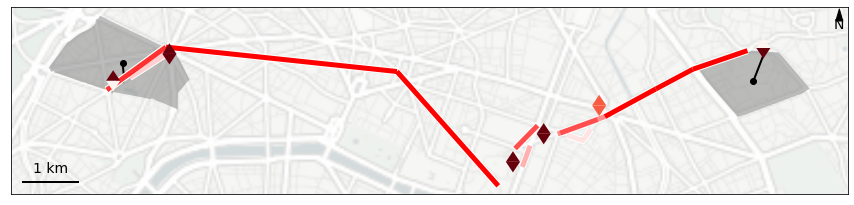

In [67]:
if manual :
    tc.nodes = gpd.GeoDataFrame(tc.nodes)
    from syspy.syspy_utils import data_visualization as dv
    plot = tc.plot_strategy(
        origin, destination, road=False, cmap='Reds', ax=None , walk_on_road=True,basemap_raster=None,
        figsize=(15, 10), legend='right', legend_kwds={'orientation': 'vertical', 'label': 'probability'},
       scalebar=False, north_arrow=True
    )
    dv.add_basemap(plot, url= 'http://a.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png', zoom=12)